## Example of likelihood maximization with iMinuit

This notebook contains the basic syntax required to run iMinuit on simulated P1D data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
import time
# our own modules
from lace.emulator import gp_emulator
from lace.emulator import nn_emulator
from cup1d.data import data_Chabanier2019
from cup1d.likelihood import likelihood
from cup1d.likelihood import iminuit_minimizer

### Set up data (eBOSS P1D measurement from Chabanier et al. 2019)

In [2]:
data=data_Chabanier2019.P1D_Chabanier2019(zmax=4.5)

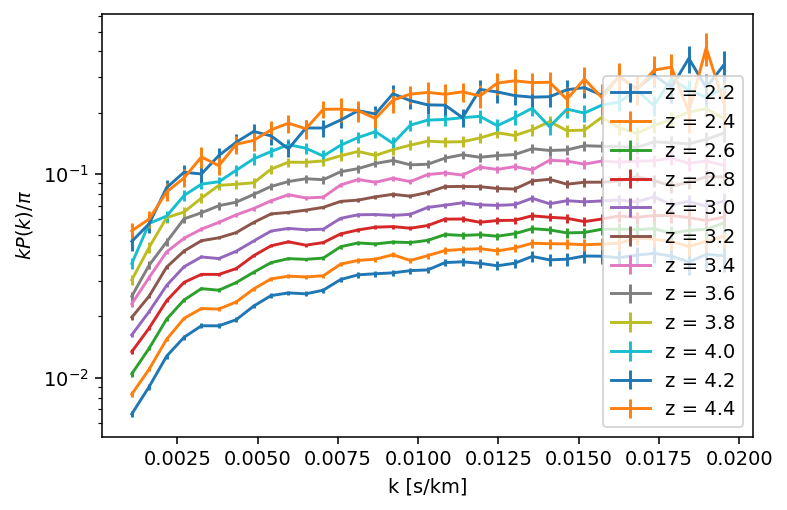

In [3]:
data.plot_p1d()

### Setup an emulator (Nyx, LaCE-GP or LaCE-NN)

In [4]:
emulator_label="LaCE-NN"
if emulator_label=="LaCE-GP":
    emulator=gp_emulator.GPEmulator(training_set="Cabayol23", emulator_label="Cabayol23")
elif emulator_label=="LaCE-NN":
    emulator=nn_emulator.NNEmulator(training_set="Cabayol23", emulator_label="Cabayol23")
elif args.emulator_label=="Nyx":
    emulator=nn_emulator.NNEmulator(training_set="Nyx23", emulator_label="Cabayol23_Nyx")
else:
    raise ValueError("wrong emulator_label",emulator_label)

Selected training set from Cabayol23
Select emulator in Cabayol23
Neural network emulating the optimal P1D of Gadget simulations fitting coefficients to a 5th degree polynomial. It goes to scales of 4Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones


### Setup a likelihood

Here we chose which parameters we want to sample, over which range and chose a prior. We pass the data and emulator objects to the likelihood.

In [5]:
free_cosmo=False
if free_cosmo:
    # stick to primordial power-law parameters here
    free_param_names=["As","ns"]
else:
    free_param_names=[]
# specify the number of free parameters per IGM function (default=2)
n_igm=2
for i in range(n_igm):
    for par in ["tau","sigT_kms","gamma","kF"]:
        free_param_names.append('ln_{}_{}'.format(par,i))

In [6]:
# option to include/remove a Gaussian prior (in unit cube)
prior_Gauss_rms=None
# option to include/ignore emulator covariance (it might bias the results)
emu_cov_factor=0
like=likelihood.Likelihood(data=data,
                            emulator=emulator,
                            free_param_names=free_param_names,
                            prior_Gauss_rms=prior_Gauss_rms,
                            emu_cov_factor=emu_cov_factor)

will not store truth, working with real data


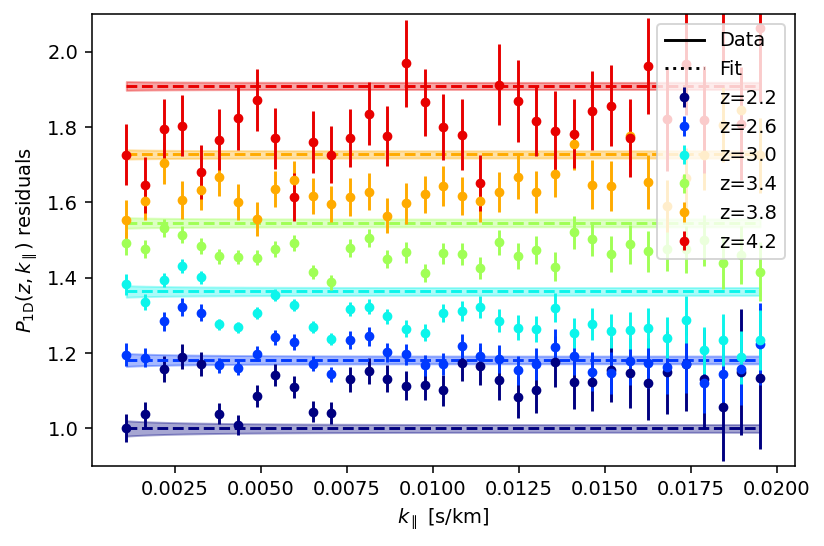

In [7]:
like.plot_p1d(residuals=True,plot_every_iz=2)

# Try iminuit minimizer

In [8]:
test_values=len(free_param_names)*[0.5]
ini_chi2=like.get_chi2(values=test_values)
print('chi2 =',ini_chi2)

chi2 = 1869.4169952663615


In [9]:
minimizer = iminuit_minimizer.IminuitMinimizer(like)

In [10]:
minimizer.minimize(compute_hesse=True)

In [11]:
best_fit_values=np.array(minimizer.minimizer.values)
best_chi2=like.get_chi2(values=best_fit_values)
print('chi2 improved from {} to {}'.format(ini_chi2,best_chi2))

chi2 improved from 1869.4169952663615 to 941.8280072476527


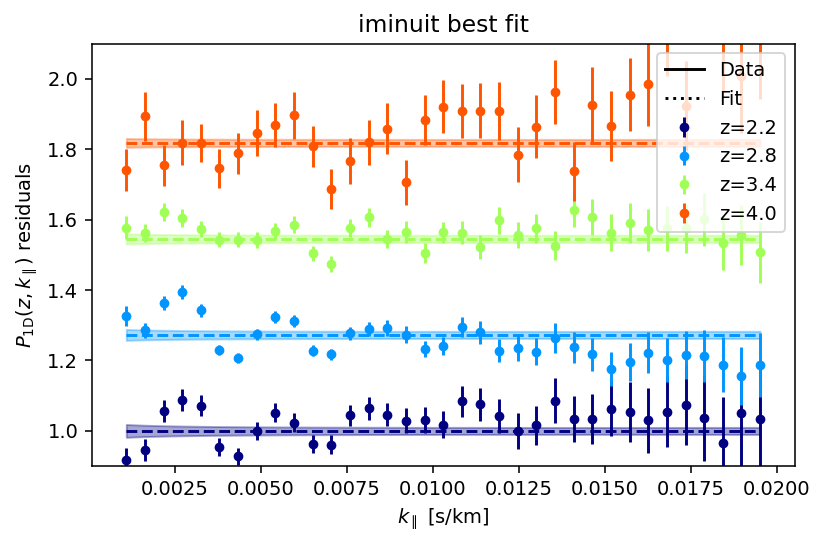

In [12]:
minimizer.plot_best_fit(plot_every_iz=3)

In [13]:
if free_cosmo:
    minimizer.plot_ellipses('As','ns')

### Access the actual minimizer object from iminuit

In [14]:
minimizer.minimizer.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 623.7                      │             Nfcn = 2494              │
│ EDM = 1.26e+207 (Goal: 0.0001)   │           time = 104.3 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │    0.5    │    0.7    │            │            │         │         │       │
│ 1 │ x1   │    0.3    │    0.7    │            │            │         │         │       │
│ 2 │ x2   │    0.6    │    0.7    │            │            │         │         │       │
│ 3 │ x3   │     0     │     6     │            │            │         │         │       │
│ 4 │ x4   │    0.0    │    0.7    │            │            │         │         │       │
│ 5 │ x5   │    0.1    │    0.7    │            │            │         │         │       │
│ 6 │ x6   │    1.0    │    0.7    │            │            │         │         │       │
│ 7 │ x7   │    1.0    │    0.7    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────────────────────────────────┐
│    │         x0         x1         x2         x3         x4         x5         x6         x7 │
├────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ x0 │      0.502  -4.42e-05     -0.002     -0.253   9.86e-32     -0.002 -2.98e-105  -1.54e-06 │
│ x1 │  -4.42e-05        0.5    4.3e-05     0.0054          0   4.22e-05  6.43e-107   3.33e-08 │
│ x2 │     -0.002    4.3e-05      0.502      0.247          0    0.00195  2.91e-105   1.51e-06 │
│ x3 │     -0.253     0.0054      0.247       31.7          0      0.246  3.68e-103    0.00019 │
│ x4 │   9.86e-32          0          0          0        0.5          0  8.08e-116          0 │
│ x5 │     -0.002   4.22e-05    0.00195      0.246          0      0.502   2.9e-105    1.5e-06 │
│ x6 │ -2.98e-105  6.43e-107  2.91e-105  3.68e-103  8.08e-116   2.9e-105        0.5  2.35e-108 │
│ x7 │  -1.54e-06   3.33e-08   1.51e-06    0.00019          0    1.5e-06  2.35e-108        0.5 │
└────┴─────────────────────────────────────────────────────────────────────────────────────────┘

In [15]:
#minimizer.minimizer.draw_mncontour("x0", "x1")

In [16]:
#minimizer.minimizer.draw_mnprofile("x0")

In [17]:
a=3